In [2]:
import pyjuice as juice
import torch
import torchvision
import time
from torch.utils.data import TensorDataset, DataLoader
import pyjuice.nodes.distributions as dists
import numpy as np
import pandas as pd

import seaborn as sns
import pandas as pd
import numpy as np
import importlib
import os
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# train_dataset = torchvision.datasets.MNIST(root = "./data", train = True, download = True)
# valid_dataset = torchvision.datasets.MNIST(root = "./data", train = False, download = True)

# train_data = train_dataset.data.reshape(60000, 28*28)
# valid_data = valid_dataset.data.reshape(10000, 28*28)

data_dir = "/u/scratch/p/panand2/genetic_pc/data1kg"
file_name = "805.data"

def load(file_name, data_dir):
    filename = f"{data_dir}/{file_name}"
    dataframe = pd.read_csv(filename, header=None,
                            true_values=["1", "2", "3"],
                            false_values=["0"], dtype=object)
    data = dataframe.iloc[:, 0].str.split(' ')
    return np.array([np.array(entry) for entry in data])

data = load(file_name, data_dir)
data = data.astype(np.int8)
print(data.shape)

total_size = len(data)
train_size = int(0.8 * total_size)
valid_size = total_size - train_size

indices = np.random.permutation(total_size)
train_indices, valid_indices = indices[:train_size], indices[train_size:]
train_data, valid_data = data[train_indices], data[valid_indices]

train_data = torch.tensor(train_data, dtype=torch.long)
valid_data = torch.tensor(valid_data, dtype=torch.long)

print(train_data.shape)
print(valid_data.shape)

train_loader = DataLoader(
    dataset = TensorDataset(train_data),
    batch_size = 512,
    shuffle = True,
    drop_last = True
)
valid_loader = DataLoader(
    dataset = TensorDataset(valid_data),
    batch_size = 512,
    shuffle = False,
    drop_last = True
)

(5008, 805)
torch.Size([4006, 805])
torch.Size([1002, 805])


In [7]:
device = torch.device("cuda:0")

# The data is required to construct the backbone Chow-Liu Tree structure for the HCLT
ns = juice.structures.HCLT(
    train_data.float().to(device),
    num_latents = 16
)

pc = juice.compile(ns)
pc.to(device)

num_epochs = 400

optimizer = juice.optim.CircuitOptimizer(pc, lr = 0.05, pseudocount = 0.001, method = "EM")
scheduler = juice.optim.CircuitScheduler(
    optimizer,
    method = "multi_linear",
    lrs = [0.05, 0.01],
    milestone_steps = [0, len(train_loader) * num_epochs]
)

Compiling 8 TensorCircuit layers...


100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


In [8]:
for batch in train_loader:
    x = batch[0].to(device)

    lls = pc(x, record_cudagraph = True)
    lls.mean().backward()
    break

In [9]:
for epoch in range(1, num_epochs+1):
    t0 = time.time()
    train_ll = 0.0
    for batch in train_loader:
        x = batch[0].to(device)

        # Similar to PyTorch optimizers zeroling out the gradients, we zero out the parameter flows
        optimizer.zero_grad()

        # Forward pass
        lls = pc(x)

        # Backward pass
        lls.mean().backward()

        train_ll += lls.mean().detach().cpu().numpy().item()

        # Perform a mini-batch EM step
        optimizer.step()
        scheduler.step()

    train_ll /= len(train_loader)

    t1 = time.time()
    test_ll = 0.0
    for batch in valid_loader:
        x = batch[0].to(pc.device)
        lls = pc(x)
        test_ll += lls.mean().detach().cpu().numpy().item()

    test_ll /= len(valid_loader)
    t2 = time.time()

    print(f"[Epoch {epoch}/{num_epochs}][train LL: {train_ll:.2f}; val LL: {test_ll:.2f}].....[train forward+backward+step {t1-t0:.2f}; val forward {t2-t1:.2f}] ")

[Epoch 1/400][train LL: -2363.29; val LL: -1371.63].....[train forward+backward+step 0.48; val forward 0.00] 
[Epoch 2/400][train LL: -1157.29; val LL: -945.94].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 3/400][train LL: -845.97; val LL: -741.03].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 4/400][train LL: -683.36; val LL: -622.63].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 5/400][train LL: -585.80; val LL: -548.56].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 6/400][train LL: -523.71; val LL: -500.14].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 7/400][train LL: -482.54; val LL: -467.62].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 8/400][train LL: -454.44; val LL: -445.38].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 9/400][train LL: -435.18; val LL: -430.02].....[train forward+backward+step 0.04; val forward 0.00] 
[Epoch 10/400][train LL: 

In [10]:
juice.save('test.jpc', pc)

In [11]:
device = torch.device("cuda:0")
ns = juice.load('test.jpc')
pc = juice.compile(ns)
pc.to(device)

Compiling 8 TensorCircuit layers...


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


TensorCircuit(
  (input_layer_group): LayerGroup(
    (layer_0): InputLayer()
  )
  (prod_layer_0): LayerGroup(
    (layer_0): ProdLayer(
      (partitioned_nids): FastParamList(
          (0): Parameter containing: [torch.int64 of size 110 (cuda:0)]
          (1): Parameter containing: [torch.int64 of size 3 (cuda:0)]
      )
      (partitioned_cids): FastParamList(
          (0): Parameter containing: [torch.int64 of size 110x4 (cuda:0)]
          (1): Parameter containing: [torch.int64 of size 3x16 (cuda:0)]
      )
      (partitioned_u_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 266 (cuda:0)])
      (partitioned_parids): FastParamList(  (0): Parameter containing: [torch.int64 of size 266x1 (cuda:0)])
    )
  )
  (sum_layer_0): LayerGroup(
    (layer_0): SumLayer(
      (partitioned_nids): FastParamList(  (0): Parameter containing: [torch.int64 of size 113 (cuda:0)])
      (partitioned_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 

In [12]:
samples = juice.queries.sample(pc, num_samples = 5008)
print(samples.shape)

torch.Size([5008, 805])


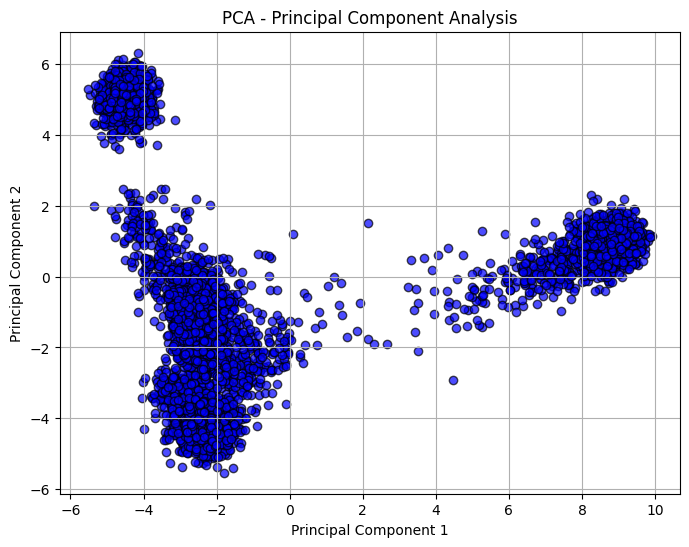

In [13]:
# Initialize PCA
data = torch.tensor(data, dtype=torch.long)

pca = PCA(n_components=2)

pca.fit(data)
# Fit and transform the data
pcs = pca.transform(data)

# pcs now contains the principal components
# pcs[:, 0] are the x-coordinates (PC1)
# pcs[:, 1] are the y-coordinates (PC2)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')
plt.grid(True)
plt.show()

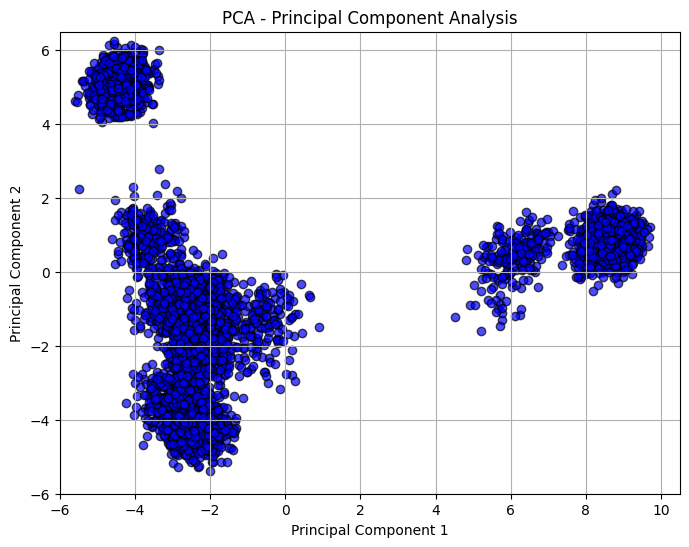

In [14]:
# Initialize PCA
pca = PCA(n_components=2)

pca.fit(data)

samples_cpu = samples.cpu()

# Fit and transform the data
# pcs1 = pca.transform(data)
pcs = pca.transform(samples_cpu)

# pcs now contains the principal components
# pcs[:, 0] are the x-coordinates (PC1)
# pcs[:, 1] are the y-coordinates (PC2)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c='blue', edgecolor='k', alpha=0.7)

# plt.scatter(pcs1[:, 0], pcs1[:, 1], c='orange', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')

plt.xlim(-6, 10.5)  # Match the x-axis range from the first plot
plt.ylim(-6, 6.5)   # Match the y-axis range from the first plot

plt.grid(True)
plt.show()